To run this python jupyter notebook: 
- [open in colab](https://colab.research.google.com/github/LowLevelML/Sentiment-Analysis-Review-Classification/blob/master/ml/main.ipynb)

# Install packages

In [1]:
%pip install datasets transformers
# %pip install cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Data

In [2]:
DATASETNAME = "emotion"

In [3]:
from datasets import load_dataset
dataset = load_dataset(DATASETNAME)

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
import torch
# import torch_xla
# import torch_xla.core.xla_model as xm
if torch.cuda.is_available():
	deviceName = "cuda"
else:
	deviceName = "cpu"

# deviceName = xm.xla_device()

print(deviceName)

device = torch.device(deviceName)

cuda


# Preprocess Data

In [5]:
MODELNAME = "bert-base-uncased" # MODELNAME = "bert-large-uncased"

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODELNAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
datasetEncoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
datasetEncoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,


In [9]:
from transformers import AutoModelForSequenceClassification, AutoConfig
# define the mappings as dictionaries
label2id = {
    "0": "Sad",
    "1": "Joy",
    "2": "Love",
    "3": "Anger",
    "4": "Fear",
    "5": "Surprise"
}
id2label = {
    "Sad": "0",
    "Joy": "1",
    "Love": "2",
    "Anger": "3",
    "Fear": "4",
    "Surprise": "5"
}
# use auto config so taht you can change model name and it will auto detect
# define config
config = AutoConfig.from_pretrained(MODELNAME, label2id=label2id, id2label=id2label)
# config done
numLabels = 6
model = (AutoModelForSequenceClassification.from_pretrained(MODELNAME, config=config).to(device))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
datasetEncoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [11]:
datasetEncoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
datasetEncoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Train the model

In [12]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [13]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(datasetEncoded["train"]) // batch_size
training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=8,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False
)

In [14]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=datasetEncoded["train"],
                  eval_dataset=datasetEncoded["validation"])

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16000
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.228703,0.920000,0.919009
2,0.484900,0.149927,0.939500,0.940056
3,0.484900,0.139446,0.938000,0.938464
4,0.106100,0.138771,0.937000,0.936772
5,0.106100,0.158684,0.937500,0.937035
6,0.066400,0.173366,0.942500,0.941876
7,0.066400,0.180069,0.939000,0.939097
8,0.043700,0.183048,0.940000,0.939813


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-250
Configuration saved in results/checkpoint-250/config.json
Model weights saved in results/checkpoint-250/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bi

TrainOutput(global_step=2000, training_loss=0.17526937389373778, metrics={'train_runtime': 1895.2821, 'train_samples_per_second': 67.536, 'train_steps_per_second': 1.055, 'total_flos': 5722870980096000.0, 'train_loss': 0.17526937389373778, 'epoch': 8.0})

In [15]:
results = trainer.evaluate()
results

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'eval_loss': 0.17336606979370117,
 'eval_accuracy': 0.9425,
 'eval_f1': 0.941876035159545,
 'eval_runtime': 8.7268,
 'eval_samples_per_second': 229.18,
 'eval_steps_per_second': 3.667,
 'epoch': 8.0}

In [16]:
preds_output = trainer.predict(datasetEncoded["validation"])
preds_output.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


{'test_loss': 0.17336606979370117,
 'test_accuracy': 0.9425,
 'test_f1': 0.941876035159545,
 'test_runtime': 8.7023,
 'test_samples_per_second': 229.825,
 'test_steps_per_second': 3.677}

# Show results in a confusion matrix

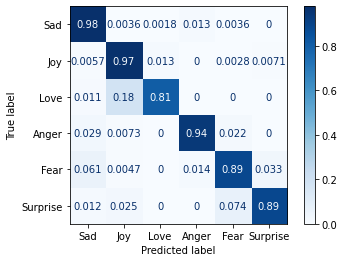

In [17]:
import numpy as np
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
def confusion_ma(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()
yValid = np.array(datasetEncoded["validation"]["label"])
yPreds = np.argmax(preds_output.predictions, axis=1)
labels = ['Sad', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
confusion_ma(yValid, yPreds, labels)

# Save model to Google Drive or Transformers

I am going to save to google drive, and then push to transformers

In [18]:
# save pytorch model
model.save_pretrained('./model')
# Save
tokenizer.save_pretrained('./model')

Configuration saved in ./model/config.json
Model weights saved in ./model/pytorch_model.bin
tokenizer config file saved in ./model/tokenizer_config.json
Special tokens file saved in ./model/special_tokens_map.json


('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

In [19]:
!cd /content && zip -r ./model.zip ./model/

  adding: model/ (stored 0%)
  adding: model/tokenizer.json (deflated 71%)
  adding: model/config.json (deflated 51%)
  adding: model/vocab.txt (deflated 53%)
  adding: model/pytorch_model.bin (deflated 7%)
  adding: model/special_tokens_map.json (deflated 42%)
  adding: model/tokenizer_config.json (deflated 41%)


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!cd /content && cp -r ./model.zip "./drive/My Drive/colabDownload/"